In [1]:
import os

rootpath = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, os.path.pardir))
print(f"{rootpath = }")

rootpath = '/home/sh0416/sentence-benchmark'


In [2]:
import sys

sys.path.append(os.path.join(rootpath, "src"))

In [3]:
from simcse.models import RobertaForTokenContrastiveLearning

In [4]:
checkpoint = os.path.join(rootpath, "result/20210915_125601/checkpoint-1500")
# checkpoint = "princeton-nlp/unsup-simcse-roberta-base"
print(f"{checkpoint = }")
model = RobertaForTokenContrastiveLearning.from_pretrained(
    checkpoint, loss_mlm=False, temp=0.05
)

checkpoint = '/home/sh0416/sentence-benchmark/result/20210915_125601/checkpoint-1500'


Some weights of the model checkpoint at /home/sh0416/sentence-benchmark/result/20210915_125601/checkpoint-1500 were not used when initializing RobertaForTokenContrastiveLearning: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForTokenContrastiveLearning from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenContrastiveLearning from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from transformers import RobertaTokenizer

In [6]:
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

In [7]:
import csv
import itertools
from simcse.data.dataset import ContrastiveLearningDataset
from torch.utils.data import DataLoader
from simcse.data.dataset import collate_fn
import functools
from sentence_benchmark.data import load_sts12

inspection_type = "test"

if inspection_type == "train":
    train_path = os.path.join(
        rootpath, "data/wiki1m_for_simcse.txt_bpedropout_0.0_roberta-base.csv"
    )
    dataset = ContrastiveLearningDataset(train_path, tokenizer)
    loader = DataLoader(
        dataset,
        batch_size=2,
        collate_fn=functools.partial(collate_fn, tokenizer=tokenizer),
    )
    for x in loader:
        break
    print(x)
else:
    filepath = os.path.join(rootpath, "data/STS/STS12-en-test")
    dataset = load_sts12(filepath)
    print(dataset["MSRpar"][0])
    example = tokenizer(
        [dataset["MSRpar"][0].input[0], dataset["MSRpar"][0].input[1]],
        return_tensors="pt",
        padding=True,
    )
    x = {
        "input_ids1": example["input_ids"],
        "input_ids2": example["input_ids"],
        "attention_mask1": example["attention_mask"],
        "attention_mask2": example["attention_mask"],
    }
    print(x)

Example(input=['the problem likely will mean corrective changes before the shuttle fleet starts flying again .', 'he said the problem needs to be corrected before the space shuttle fleet is cleared to fly again .'], score=4.4)
{'input_ids1': tensor([[    0,   627,   936,   533,    40,  1266, 31378,  1022,   137,     5,
         19463,  7620,  2012,  4731,   456,   479,     2,     1,     1,     1,
             1],
        [    0,   700,    26,     5,   936,   782,     7,    28, 17261,   137,
             5,   980, 19463,  7620,    16,  6049,     7,  3598,   456,   479,
             2]]), 'input_ids2': tensor([[    0,   627,   936,   533,    40,  1266, 31378,  1022,   137,     5,
         19463,  7620,  2012,  4731,   456,   479,     2,     1,     1,     1,
             1],
        [    0,   700,    26,     5,   936,   782,     7,    28, 17261,   137,
             5,   980, 19463,  7620,    16,  6049,     7,  3598,   456,   479,
             2]]), 'attention_mask1': tensor([[1, 1, 1, 1, 

In [8]:
model.compute_similarity(**x)

tensor([1., 1.], grad_fn=<DivBackward0>)

In [9]:
outputs1, outputs2 = model._compute_representation(**x)

In [10]:
attention_mask1 = x["attention_mask1"]
attention_mask2 = x["attention_mask2"]
sim = model._compute_pairwise_similarity(
    outputs1[:, None, :, :],
    outputs2[None, :, :, :],
    attention_mask1[:, None, :],
    attention_mask2[None, :, :],
)

In [11]:
sim.max(dim=3)

torch.return_types.max(
values=tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000,   -inf,   -inf,   -inf,   -inf],
         [0.7496, 0.6306, 0.7486, 0.5794, 0.6093, 0.5928, 0.6471, 0.5989,
          0.7397, 0.7043, 0.7842, 0.7526, 0.6374, 0.6991, 0.7225, 0.7451,
          0.7188,   -inf,   -inf,   -inf,   -inf]],

        [[0.7496, 0.5291, 0.5953, 0.6636, 0.7486, 0.5942, 0.6093, 0.6009,
          0.6471, 0.7397, 0.7043, 0.6766, 0.7842, 0.7526, 0.6374, 0.5603,
          0.6247, 0.6991, 0.7225, 0.7451, 0.7188],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]], grad_fn=<MaxBackward0>),
indices=tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
           0,  0,  0,  0],
         [ 0,  3,  4,  4,  6,  

In [12]:
import torch.nn.functional as F
import matplotlib.pyplot as plt


# pairwise = F.cosine_similarity(outputs1[0], outputs2[0, None, :, :], dim=2)

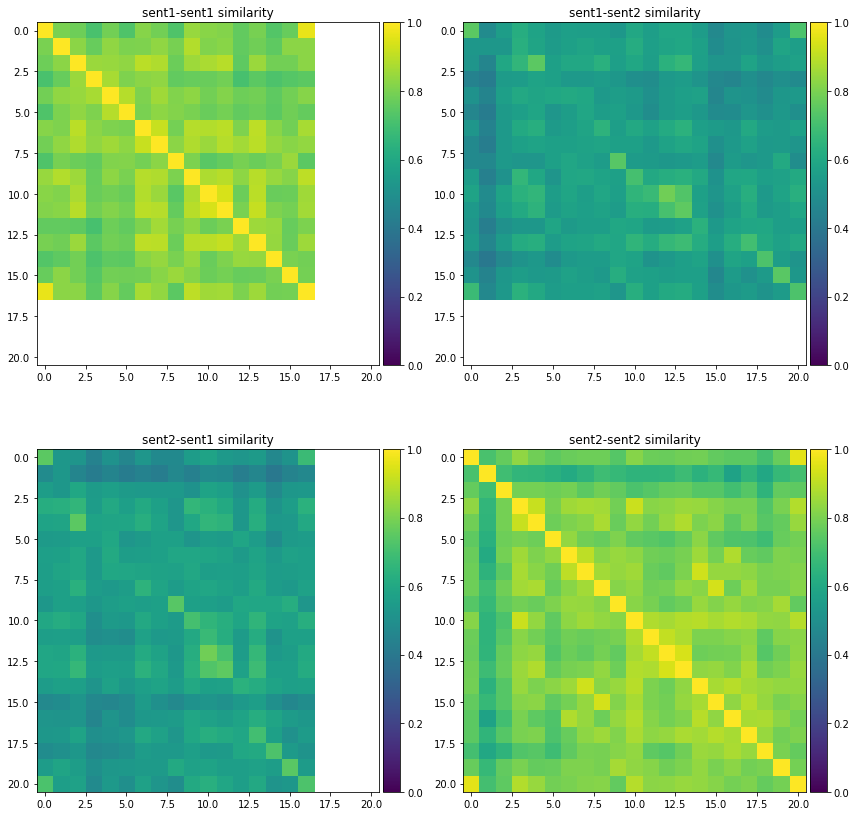

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.patch.set_facecolor("#ffffff")


def plot(x, title, ax):
    ax.set_title(title)
    im = ax.imshow(x.detach().numpy(), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


plot(sim[0, 0], "sent1-sent1 similarity", axes[0, 0])
plot(sim[0, 1], "sent1-sent2 similarity", axes[0, 1])
plot(sim[1, 0], "sent2-sent1 similarity", axes[1, 0])
plot(sim[1, 1], "sent2-sent2 similarity", axes[1, 1])
# plt.show()
plt.tight_layout()
plt.savefig(
    f"3-inspect-model-activation-{os.path.basename(checkpoint)}-{inspection_type}.png"
)